In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from check_differences import main as measure_bias
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [15]:
base_models = ["bert", "bert_multilingual", "roberta", "bert_1_layer", "bert_3_layer", "bert_6_layer"]
seeds = [123, 72, 93]
folder = "models"
settings = ["prefix", "lora", ""]
middle = "python-150"

In [16]:
def draw_bias(model):
    result = {}
    for setting in settings:
        if setting == "":
            name = model
        else:
            name = f"{model}_{setting}"
        result[name] = {}
        for base_model in base_models:
            result[name][base_model] = []

            for seed in seeds:
                if setting == "":
                    data_path = f"{folder}/{seed}/{name}/{model}_{middle}.bin.pkl"
                else:
                    data_path = f"{folder}/{seed}/{name}/{model}_{middle}_{setting}.bin.pkl"
                data_control_path = f"{folder}/{seed}/{base_model}/{base_model}_{middle}.bin.pkl"
                bias = measure_bias(data_path, data_control_path)
                # print(f"{name} {base_model} {bias}")
                result[name][base_model].append(bias)

    model_bias = {}
    for model in result:
        model_bias[model] = []
        for base_model in result[model]:
            model_bias[model].append(sum(result[model][base_model]) / len(result[model][base_model]))

    keys = list(model_bias.keys())
    values = [model_bias[key] for key in keys]

    plt.figure(figsize=(10, 5))
    plt.boxplot(values)
    plt.xticks(range(1, len(keys) + 1), keys)
    plt.ylabel("Bias")
    plt.title("Bias of models")
    plt.show()

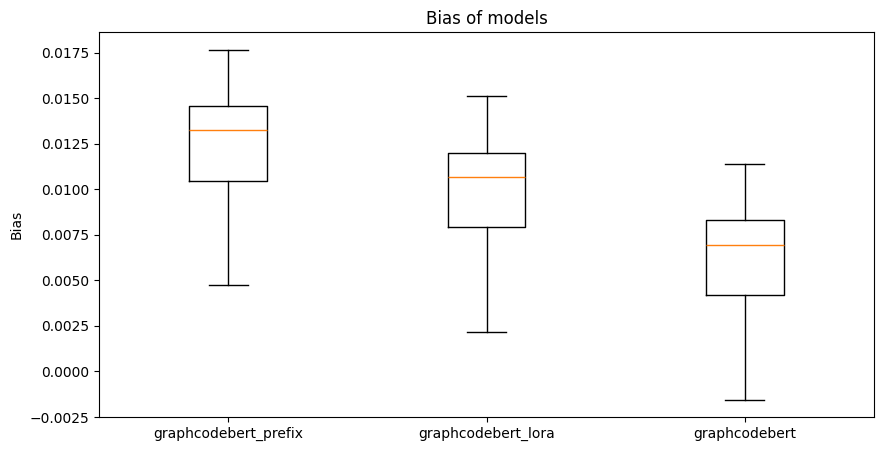

In [17]:
draw_bias("graphcodebert")

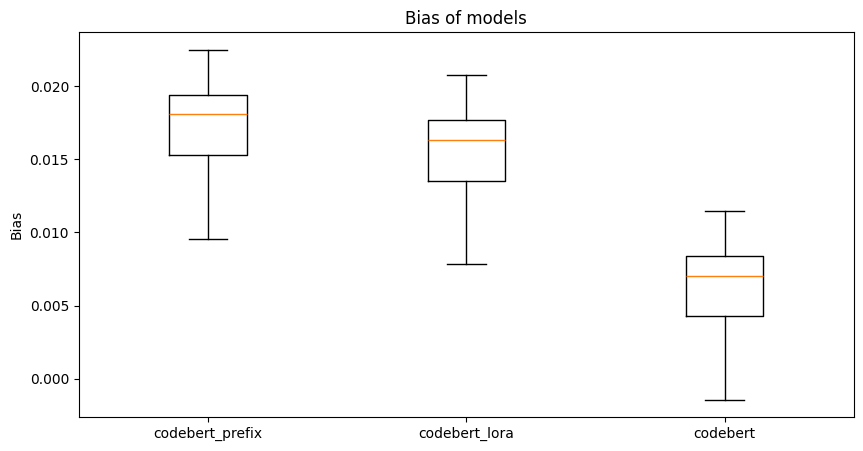

In [38]:
draw_bias("codebert")

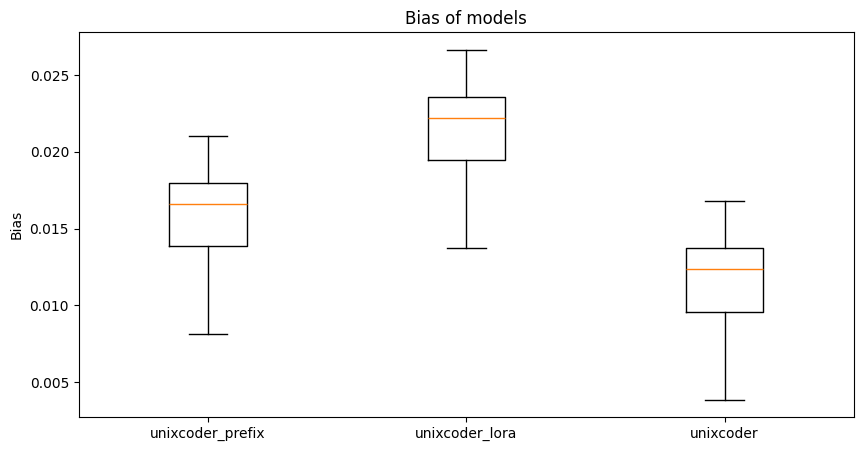

In [39]:
draw_bias("unixcoder")

## Layer-wise

In [37]:
model_name = "graphcodebert"
base_models = ["bert", "bert_multilingual", "roberta", "bert_1_layer", "bert_3_layer", "bert_6_layer"]
setting = "telly"
seeds = [123, 72, 93]
folder = "models"
middle = "python-150"
layers = range(1, 13)

In [38]:
results = []
for layer in layers:
    layer_results = []
    for base_model in base_models:
        for seed in seeds:
            data_path = f"{folder}/{seed}/{setting}/{model_name}_{middle}_{setting}{layer}.bin.pkl"
            data_control_path = f"{folder}/{seed}/{base_model}/{base_model}_{middle}.bin.pkl"
            bias = measure_bias(data_path, data_control_path)
            layer_results.append(bias)
    results.append((layer, sum(layer_results) / len(layer_results), base_model))


Text(0.5, 1.0, 'Bias of models')

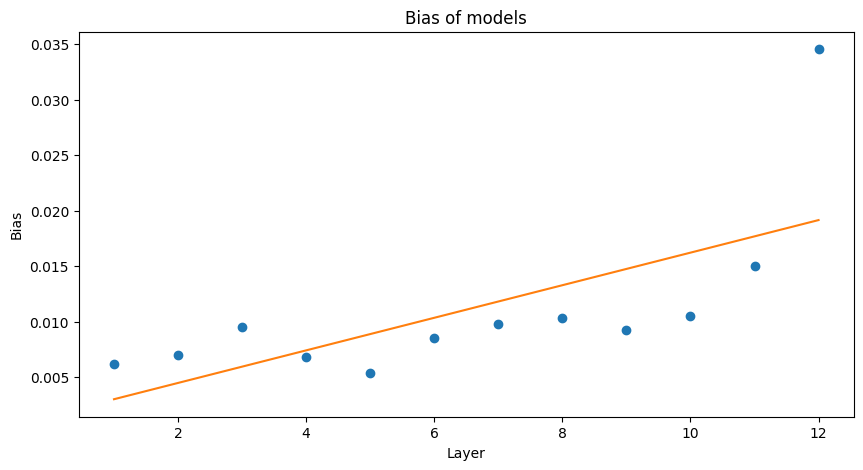

In [39]:
from scipy.interpolate import interp1d

x = [result[0] for result in results]
y = [result[1] for result in results]
m,b = np.polyfit(x, y, 1)
f = lambda x: m*np.array(x) + b


plt.figure(figsize=(10, 5))
plt.plot(x, y, 'o', x, f(x), '-')
plt.xlabel("Layer")
plt.ylabel("Bias")
plt.title("Bias of models")

## Get the metric value

### Settings

In [61]:
from check_differences import get_metric

In [62]:
base_models = ["bert", "bert_multilingual", "roberta", "bert_1_layer", "bert_3_layer", "bert_6_layer"]
finetune_models = ["graphcodebert", "codebert", "unixcoder"]
settings = ["prefix", "lora", "ff"]
seeds = [123, 72, 93]
folder = "models"
middle = "python-150"

models = base_models
for model in finetune_models:
    for setting in settings:
        models.append(f"{model}_{setting}")

In [63]:
results = []
for model in models:
    for seed in seeds:
        model_folder = model
        if "lora" in model or "prefix" in model:
            parts = model.rsplit("_", maxsplit=1)
            filename = f"{parts[0]}_{middle}_{parts[1]}"
        elif "ff" in model:
            parts = model.rsplit("_", maxsplit=1)
            model_folder = parts[0]
            filename = f"{parts[0]}_{middle}"
        else:
            filename = f"{model}_{middle}"
        data_path = f"{folder}/{seed}/{model_folder}/{filename}.bin.pkl"
        dup, non_dup, total = get_metric(data_path)

        result = {
            "model": model,
            "seed": seed,
            "dup": dup,
            "no_dup": non_dup,
            "total": total
        }
        results.append(result)

In [64]:
dataframe = pd.DataFrame(results)
dataframe.to_csv("results_codesearch.csv")

### Layerwise

In [65]:
model_name = "graphcodebert"
setting = "telly"
seeds = [123, 72, 93]
folder = "models"
middle = "python-150"
layers = range(1, 13)

In [67]:
results = []
for seed in seeds:
    for layer in layers:
        data_path = f"{folder}/{seed}/{setting}/{model_name}_{middle}_{setting}{layer}.bin.pkl"
        dup, non_dup, total = get_metric(data_path)
        result = {
            "model": model_name,
            "seed": seed,
            "layer": layer,
            "dup": dup,
            "no_dup": non_dup,
            "total": total
        }
        results.append(result)

dataframe = pd.DataFrame(results)
dataframe.to_csv(f"results_codesearch_layered.csv")